In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from operator import itemgetter

from utils import draw_matches, get_inliers_homography, Ransac_DLT_homography

def create_detector(name, nfeatures  = 2000):
    if name == 'orb':
        detector = cv2.ORB_create(nfeatures=nfeatures)
    else: detector = cv2.SIFT_create(nfeatures=nfeatures)   
    return detector

def get_features(img, detector_name = 'orb',):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    detector = create_detector(detector_name)
    kps, descs = detector.detectAndCompute(gray, None)
    return kps, descs, img.shape[:2][::-1]

def features_to_kp(img, logo_features, ratio = .8, desc = 'orb', nmatches = 15):
    train_kps, train_descs, shape = logo_features
    kps, descs, _ = get_features(img, detector_name=desc)    
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(train_descs, descs, k=2)
    
    return kps, train_kps, matches, #sorted(matches, key = lambda x:x.distance)[:nmatches]



def match_template(template, target, margin = -20):
    
    res = cv2.matchTemplate(target,template, cv2.TM_CCOEFF)
    w, h, _ = template.shape

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = max_loc
    bottom_right = (top_left[0] + w + margin, top_left[1] + h+margin)
    top_left = top_left[0] - margin, top_left[1] - margin
    target_blanked = np.zeros_like(target)
    
    cv2.rectangle(target_blanked,top_left, bottom_right, (255, 255, 255), -1)
    final_target = (0!=target_blanked) * target

    return target_blanked, final_target


def get_logo_corners(template, target):
    
    res = cv2.matchTemplate(target,template, cv2.TM_CCOEFF)
    w, h, _ = template.shape
    plt.imshow(res)
    plt.show()
    

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
def kp_match(img1, img2, descr='orb', dist_th=0.85):

    if descr=='orb':
        descr = cv2.ORB_create()
    else:
        descr = cv2.SIFT_create()   

    kp1, d1 = descr.detectAndCompute(img1, None)
    kp2, d2 = descr.detectAndCompute(img2, None)

    # match keypoints
    bf_matcher = cv2.BFMatcher()
    matches = bf_matcher.knnMatch(d1, d2, k=2)
    # Filter with Lowe's ratio test
    _matches = []
    for m,n in matches:
        if m.distance < dist_th * n.distance:
            _matches.append([m])

    return kp1, kp2, _matches


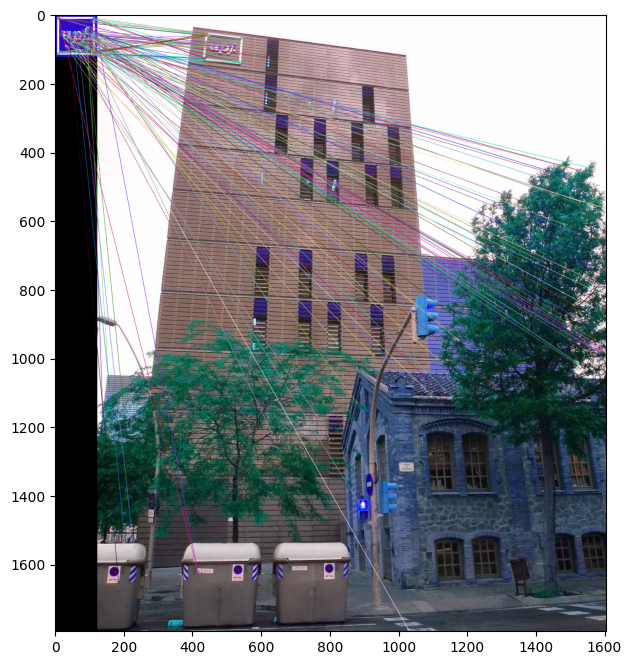

In [2]:


template = cv2.imread('/home/adri/Desktop/master/M4/MCV-M4-3D-Vision/lab2/Data/logos/logoUPF.png', cv2.IMREAD_COLOR)
target = cv2.imread('/home/adri/Desktop/master/M4/MCV-M4-3D-Vision/lab2/Data/logos/UPFbuilding.jpg', cv2.IMREAD_COLOR)
#print(template, target)

desc = 'sift'

target_kps, template_kps, m = features_to_kp(target, get_features(template, desc), desc = desc)
draw_matches(template, template_kps, target, target_kps, m)

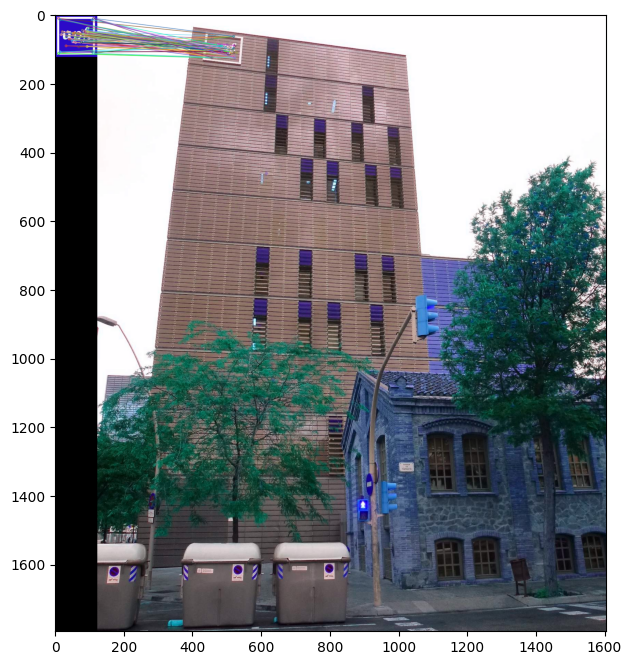

In [3]:
dsc = 'orb'
mask, reduced_target = match_template(template, target, margin = - 27)
target_kps, template_kps, m = features_to_kp(reduced_target, get_features(template, desc), desc = desc)
draw_matches(template, template_kps, target, target_kps, m)


In [60]:
kp1, kp2, matches_12 = kp_match(template, reduced_target, descr='sift', dist_th=0.9) 

In [61]:
P1, P2, H_12, idxs_inlier_matches_12 = get_inliers_homography(kp1, kp2, matches_12)
inlier_matches_12 = itemgetter(*idxs_inlier_matches_12)(matches_12)


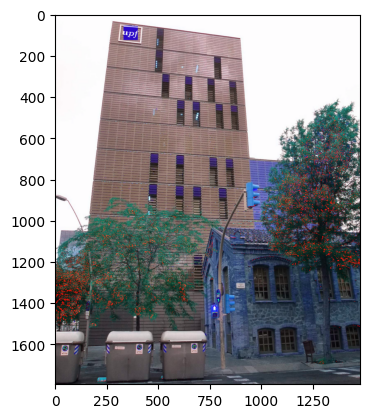

In [65]:
dst = cv2.warpPerspective(template, H_12, target.shape[:-1][::-1])
plt.imshow(~(dst * mask + target * ~mask))
plt.show()

In [8]:
def logo_substitution(template, target, new_logo):
    
    dsc = 'orb'
    mask, reduced_target = match_template(template, target, margin = - 27)
    kp1, kp2, matches_12 = kp_match(template, reduced_target, descr='sift', dist_th=0.9) 
    P1, P2, H_12, idxs_inlier_matches_12 = get_inliers_homography(kp1, kp2, matches_12)
    inlier_matches_12 = itemgetter(*idxs_inlier_matches_12)(matches_12)
    dst = cv2.warpPerspective(new_logo, H_12, target.shape[:-1][::-1])
    plt.imshow(~(dst * mask + target * ~mask))
    plt.show()


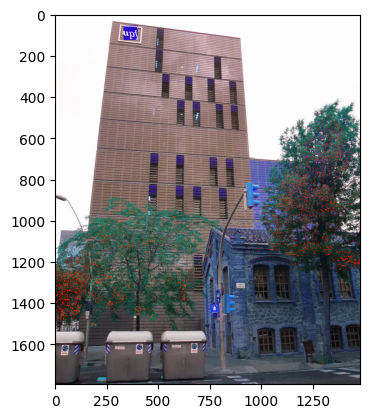

In [40]:

newlogo = cv2.imread('./Data/logos/logo_master.png', cv2.IMREAD_COLOR)
logo_substitution(template, target.copy(), template.copy())